# Covid 19 Patient Status Prediction

## 1. Problem Definition

**Problem statement**
<br>When the pandemic occurs, flattening the curve helps us to fight against the virus. It is very important to properally and efficiently distrubte the limited medical resources. If we can fastly and accuratly determine if a patient is in severe status, we can better distribute the medical resources. In this project, I build a fast and accurate model to classify the Covid 19 patients into two classes: the positive class is in high risk, who should go to the hospital to use the equipments; the negative class is in good status, who could stay at home to take medicine and have a good rest.

**Inputs**
1. age: age of the patient
2. age_band: age in the unit of decade
3. background_diseases: disease history of the patient
4. background_diseases_binary: whether the patient has a disease history
5. city: city where the patient is from
6. confirmed_date: date when the patient was confirmed with covid 19
7. country: country where the patient is from
8. date_onset_symptoms: date when the patient showed symptoms
9. deceased_date: date when the patient deceased
10. infected_by: number of people the patient was infected by
11. infection_place: where the patient was infected
12. region: region where the patient is from
13. released_date: date when the patient was released
14. return_date: date when the patient returned from travel
15. severity_illness: status of the patient
16. sex: gender of the patient
17. smoking: whether the patient smokes or not
18. symptoms: symptoms of the patient
19. treatment: treatment to the patient
20. id: number index of the patient
21. return_date_until_date_onset_symptoms: days between return and onset of symptoms
22. date_onset_symptoms_until_confirmed_date: days between onset of symptoms and confirmation
23. confirmed_date_until_released_date: days between confirmation and released
24. confirmed_date_until_deceased_date: days between confirmation and deceased
25. severity_illness_infectious_person: status of the infectious person

**Target**
<br>is_severe = 1 (severity_illness is critical or deceased) or 0 (otherwise)

**Machine learning**
<br>1, Predict severity of a patient based on given informations by applying different models
<br>2, Choose the best model and find out the important features closely related to severity

**Metrics**
<br>Model performance can be evaluated in different ways, here roc_auc is used for classification
<br>ROC_AUC: an ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. It plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. AUC stands for "Area under the ROC Curve." That is, ROC_AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).
<br>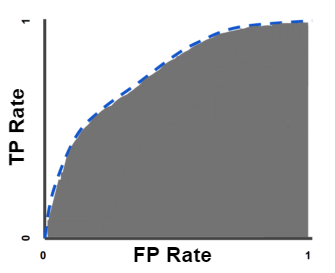

## 2. Pre-model Analysis

In [380]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as mn

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [381]:
raw_df = pd.read_csv("Kaggle_COVID19_version6_9-5-20.csv")

In [382]:
raw_df.info()
raw_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628730 entries, 0 to 628729
Data columns (total 25 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   age                                       148458 non-null  float64
 1   age_band                                  148840 non-null  float64
 2   background_diseases                       44836 non-null   object 
 3   background_diseases_binary                520061 non-null  float64
 4   city                                      350825 non-null  object 
 5   confirmed_date                            625211 non-null  object 
 6   country                                   627729 non-null  object 
 7   date_onset_symptoms                       130769 non-null  object 
 8   deceased_date                             5353 non-null    object 
 9   infected_by                               1653 non-null    object 
 10  infection_place     

,age,age_band,background_diseases_binary,smoking,id,return_date_until_date_onset_symptoms,date_onset_symptoms_until_confirmed_date,confirmed_date_until_released_date,confirmed_date_until_deceased_date
count,148458.000000,148840.000000,520061.000000,116726.000000,628730.000000,1383.000000,130652.000000,4924.000000,5306.000000
mean,42.550941,38.113881,0.086234,0.096337,314364.500000,3.295734,4.082701,16.639521,4.951376
std,17.476798,17.616720,0.280710,0.295054,181498.861711,8.365564,51.046245,9.904881,6.080383
min,0.000000,0.000000,0.000000,0.000000,0.000000,-33.000000,-18382.000000,-25.000000,-29.000000
25%,30.000000,30.000000,0.000000,0.000000,157182.250000,0.000000,1.000000,9.000000,1.000000
50%,41.000000,40.000000,0.000000,0.000000,314364.500000,2.000000,3.000000,14.000000,3.000000
75%,54.000000,50.000000,0.000000,0.000000,471546.750000,6.000000,6.000000,22.000000,8.000000
max,113.000000,110.000000,1.000000,1.000000,628729.000000,100.000000,91.000000,68.000000,91.000000


In [383]:
# Missing data
def missing(df):
    '''take a dataframe DF and return a summary of the missing data for each column'''
    total = df.isnull().sum()
    percent = df.isnull().sum()/df.isnull().count()
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).sort_values("Total", ascending=False)
    return missing_data

missing(raw_df)

,Total,Percent
severity_illness_infectious_person,628442,0.999542
return_date_until_date_onset_symptoms,627347,0.997800
symptoms,627099,0.997406
infected_by,627077,0.997371
return_date,626356,0.996224
confirmed_date_until_released_date,623806,0.992168
released_date,623802,0.992162
confirmed_date_until_deceased_date,623424,0.991561
deceased_date,623377,0.991486
infection_place,617333,0.981873


* There are too many missing values in this dataframe

In [384]:
# check data fullness by countries
g = raw_df.groupby(by="country")
countries = []
counts = []
fullness = []
for country, df in g:
    countries.append(country)
    counts.append(len(df))
    fullness.append(df.count().mean() / len(df))
f_df = pd.DataFrame({"country": countries, "count": counts, "fullness": fullness}).sort_values("fullness", ascending=False)
f_df[f_df["fullness"] > 0.4]

,country,count,fullness
82,nepal,2,0.680000
18,cambodia,2,0.600000
12,bhutan,2,0.560000
133,vietnam,305,0.488393
23,colombia,10428,0.473429
37,gambia,6,0.460000
63,korea,3362,0.448685
103,romania,25,0.448000
78,moldova,1,0.440000
32,england,1,0.440000


* Among all the contry data with at least 40% fullness. Patient data from Mexico has the largest volume. We will choose the Mexico patient data for further analysis.

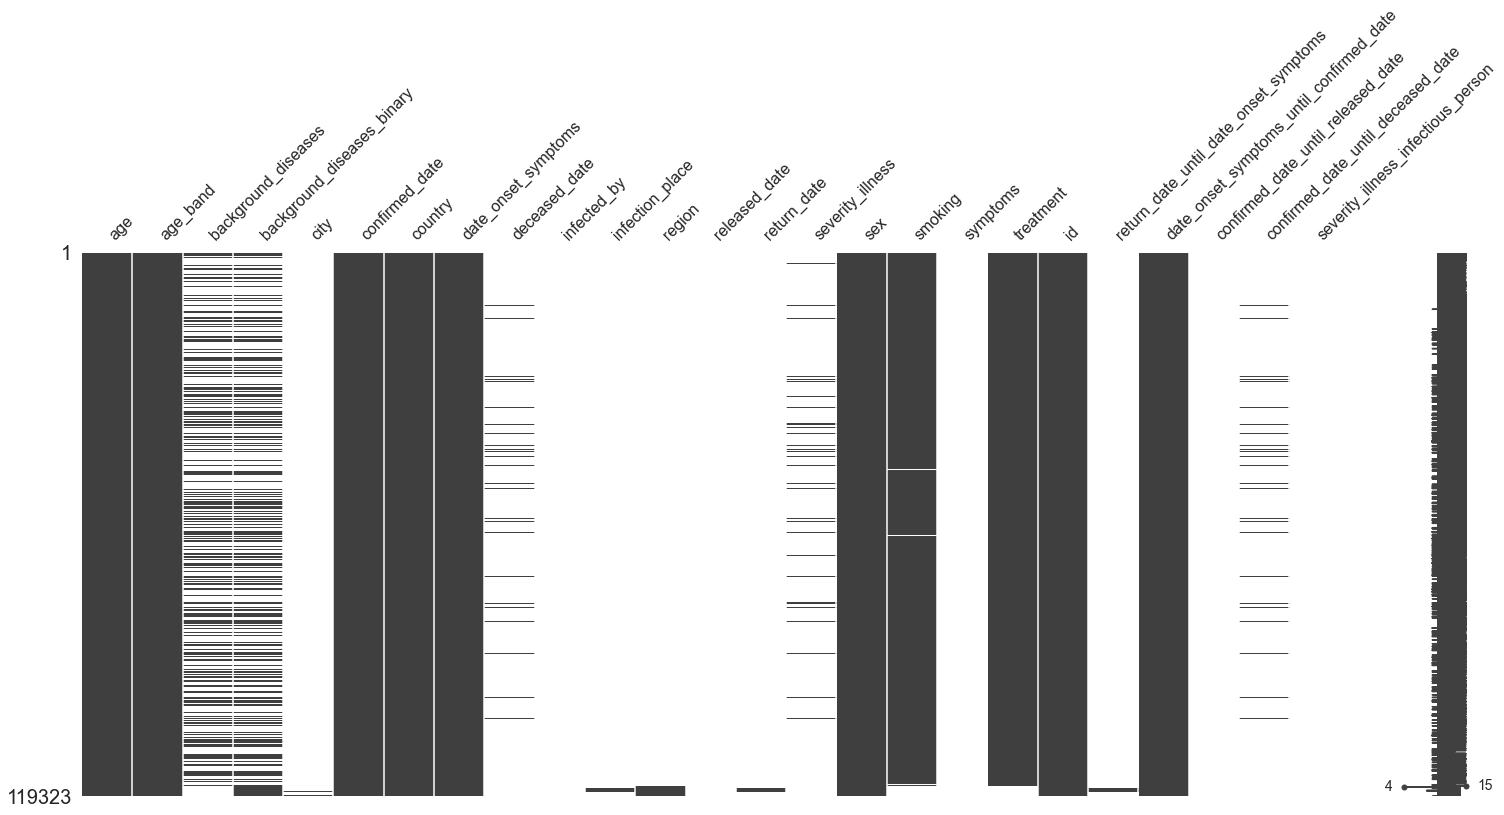

In [385]:
mex_df = g.get_group("mexico")
mn.matrix(mex_df)

In [386]:
# Missing data for Mexico
ms_df = missing(mex_df)
ms_df

,Total,Percent
released_date,119323,1.000000
infected_by,119323,1.000000
confirmed_date_until_released_date,119323,1.000000
symptoms,119323,1.000000
severity_illness_infectious_person,119323,1.000000
city,118781,0.995458
return_date_until_date_onset_symptoms,118657,0.994419
return_date,118655,0.994402
infection_place,118645,0.994318
region,117215,0.982334


* All other columns with more than 90% missing data would be dropped, except for severity_illness, which will be used to generate our target is_severe. 
* Country will be dropped, as it has only one value Mexico. 
* Id will also be dropped, as it only labels the patient number index.

## 3. Feature Engineering

### 3.1 Drop sparse features

In [404]:
# drop columns with large missing values
df = mex_df[['background_diseases', 'background_diseases_binary', 'smoking', 'treatment', 
             'date_onset_symptoms_until_confirmed_date', 'confirmed_date', 'sex', 'date_onset_symptoms', 
             'age_band', 'age', 'severity_illness']].reset_index(drop=True)
df = df.rename(columns={'date_onset_symptoms_until_confirmed_date': 'days_apart'})
df.head()

,background_diseases,background_diseases_binary,smoking,treatment,days_apart,confirmed_date,sex,date_onset_symptoms,age_band,age,severity_illness
0,NaN,NaN,1.0,clinic,0.0,2020-01-28,female,2020-01-28,20.0,26.0,NaN
1,"diabetes, hypertension,",1.0,0.0,hospitalized,0.0,2020-03-16,female,2020-03-16,40.0,47.0,deceased
2,NaN,NaN,0.0,clinic,2.0,2020-03-20,male,2020-03-18,40.0,48.0,NaN
3,"diabetes, hypertension,",1.0,0.0,hospitalized,5.0,2020-03-25,male,2020-03-20,50.0,51.0,NaN
4,"diabetes,",1.0,0.0,hospitalized,0.0,2020-03-23,female,2020-03-23,60.0,61.0,NaN


### 3.2 Background disease

In [405]:
df['background_diseases_binary'].unique()

array([nan,  1.,  0.])

In [406]:
c1 = df[df['background_diseases'].notnull() & (df['background_diseases_binary'].isnull())]
c2 = df[df['background_diseases'].isnull() & (df['background_diseases_binary'].isnull())]
c3 = df[df['background_diseases'].notnull() & (df['background_diseases_binary']==0)]
c4 = df[df['background_diseases'].isnull() & (df['background_diseases_binary']==0)]
c5 = df[df['background_diseases'].notnull() & (df['background_diseases_binary']==1)]
c6 = df[df['background_diseases'].isnull() & (df['background_diseases_binary']==1)]
print("No background_diseases_binary record and has background_diseases record:", len(c1))
print("No background_diseases_binary record and no background_diseases record:", len(c2))
print("Background_diseases_binary = 0 and has background_diseases record:", len(c3))
print("Background_diseases_binary = 0 and no background_diseases record:", len(c4))
print("Background_diseases_binary = 1 and has background_diseases record:", len(c5))
print("Background_diseases_binary = 1 and no background_diseases record:", len(c6))

No background_diseases_binary record and has background_diseases record: 0
No background_diseases_binary record and no background_diseases record: 72596
Background_diseases_binary = 0 and has background_diseases record: 0
Background_diseases_binary = 0 and no background_diseases record: 2112
Background_diseases_binary = 1 and has background_diseases record: 44615
Background_diseases_binary = 1 and no background_diseases record: 0


1. All patients with background_diseases_binary of 1 has background_diseases record and all patients without background_diseases_binary of 1 has no background_diseases record.
2. We will fill the null background_diseases values with background_diseases_binary of 0 as no_disease
3. We will fill the null background_diseases values with also null background_diseases_binary as unknown_disease
4. With these labels, we can one-hot encode the new background_diseases and drop the background_diseases_binary

In [407]:
# one-hot encode background_diseases
idx_unknown = df[df['background_diseases'].isnull() & (df['background_diseases_binary'].isnull())].index
idx_no = df[df['background_diseases'].isnull() & (df['background_diseases_binary']==0)].index

new_bd = []
for idx in range(len(dh)):
    if idx in idx_unknown:
        new_bd.append("unknown_disease")
    elif idx in idx_no:
        new_bd.append("no_disease")
    else:
        new_bd.append(df['background_diseases'][idx])

vectorizer = CountVectorizer()
new_bd = vectorizer.fit_transform(new_bd)
new_bd_df = pd.DataFrame(new_bd.todense(), columns=vectorizer.get_feature_names())
new_bd_df.head()

,asthma,cardiovascular,diabetes,failure,hypertension,immunosuppression,kidney,no_disease,obesity,unknown_disease
0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [408]:
# concatenate the new_bd_df with old df
df = pd.concat([df, new_bd_df], axis=1).drop(['background_diseases', 'background_diseases_binary'], axis=1)
df.head()

,smoking,treatment,days_apart,confirmed_date,sex,date_onset_symptoms,age_band,age,severity_illness,asthma,cardiovascular,diabetes,failure,hypertension,immunosuppression,kidney,no_disease,obesity,unknown_disease
0,1.0,clinic,0.0,2020-01-28,female,2020-01-28,20.0,26.0,NaN,0,0,0,0,0,0,0,0,0,1
1,0.0,hospitalized,0.0,2020-03-16,female,2020-03-16,40.0,47.0,deceased,0,0,1,0,1,0,0,0,0,0
2,0.0,clinic,2.0,2020-03-20,male,2020-03-18,40.0,48.0,NaN,0,0,0,0,0,0,0,0,0,1
3,0.0,hospitalized,5.0,2020-03-25,male,2020-03-20,50.0,51.0,NaN,0,0,1,0,1,0,0,0,0,0
4,0.0,hospitalized,0.0,2020-03-23,female,2020-03-23,60.0,61.0,NaN,0,0,1,0,0,0,0,0,0,0


### 3.3 Smoking

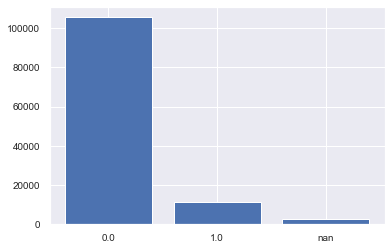

In [409]:
smk = df['smoking'].value_counts(dropna=False)
plt.bar(smk.index.astype("str"), smk.values)
plt.show()

* Replace missing values of smoking with the mode value

In [410]:
df.fillna({'smoking': df['smoking'].mode()[0]}, inplace=True)
df['smoking'].value_counts(dropna=False)

0.0    108078
1.0     11245
Name: smoking, dtype: int64

### 3.4 Treatment

* Treatment information is not useful for predicting if the patient is in severe status. We will drop this feature.

In [411]:
df.drop(columns=['treatment'], inplace=True)

### 3.5 Days apart, confirmed date and date onset symptoms

* Days_apart is the difference between confirmed_date subtract date_onset_symptoms. Thus we only keep days_apart. As the missing values of days_apart is than 0.1%. We will drop the missing values.

In [412]:
df.drop(columns=['date_onset_symptoms', 'confirmed_date'], inplace=True)
df.dropna(subset=['days_apart'], inplace=True)

### 3.6 Sex

In [413]:
df['sex'].value_counts(dropna=False)

female    60683
male      58552
NaN          22
Name: sex, dtype: int64

* We will drop the missing values encode sex as is_female

In [414]:
df.dropna(subset=['sex'], inplace=True)
df['is_female'] = df['sex'].apply(lambda x: 1 if x == 'female' else 0)
df.drop(columns='sex', inplace=True)

### 3.7 Age and age band

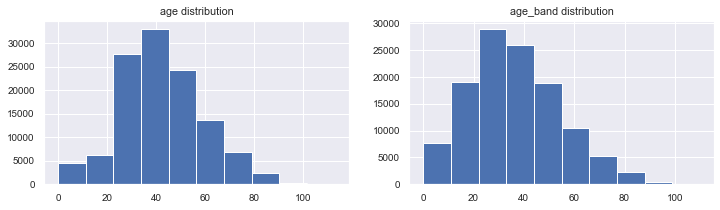

In [416]:
# Distribution of age and age_band
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
ax1.hist(df.age)
ax1.set_title('age distribution')
ax2.hist(df.age_band)
ax2.set_title('age_band distribution')
plt.show()

* Age band gives the same information as age, but in worse resolution. Thus we just drop the column age_band

In [417]:
df.drop(columns='age_band', inplace=True)

### 3.8 Generate target

In [419]:
# generate target is_severe
mex_df["severity_illness"].unique()

array([nan, 'deceased', 'critical'], dtype=object)

In [420]:
len(mex_df[mex_df['deceased_date'].notnull() & mex_df['severity_illness'].isnull()])

0

* **For all the Mexico patients, the recorded severity_illness has only three values: non, critical and deceased. All the deceased patients (with deceased_date) have a notnull severity_illness. Thus we can consider that patients with notnull severity_illness are in the status of is_severe, while patients with null severity_illness are not in severe status.**

In [421]:
# Generate target is_severe = 1 ('critical' and 'deceased') and 0 (else) and drop column severity_illness

df['severity_illness'] = df['severity_illness'].apply(lambda x: 1 if str(x)!='nan' else 0)
df = df.rename(columns={'severity_illness': 'is_severe'})

### 3.9 Clean data overview

In [422]:
df.reset_index(drop=True, inplace=True)
df.head()

,smoking,days_apart,age,is_severe,asthma,cardiovascular,diabetes,failure,hypertension,immunosuppression,kidney,no_disease,obesity,unknown_disease,is_female
0,1.0,0.0,26.0,0,0,0,0,0,0,0,0,0,0,1,1
1,0.0,0.0,47.0,1,0,0,1,0,1,0,0,0,0,0,1
2,0.0,2.0,48.0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,5.0,51.0,0,0,0,1,0,1,0,0,0,0,0,0
4,0.0,0.0,61.0,0,0,0,1,0,0,0,0,0,0,0,1


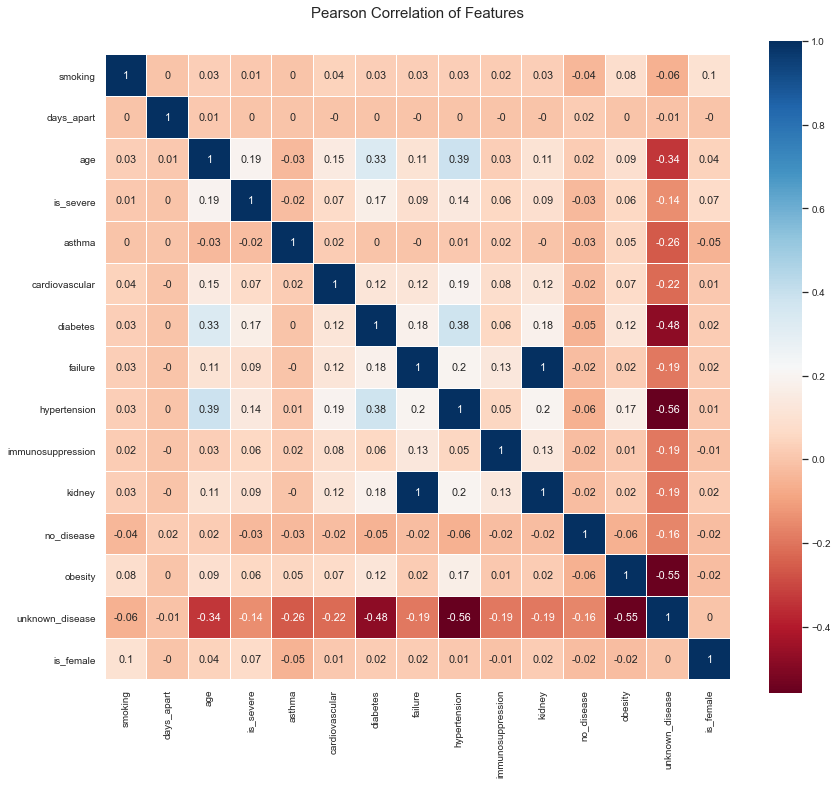

In [423]:
def pea_corr(df):
    '''helper function for correlation analysis'''
    colormap = plt.cm.RdBu
    corr = df.astype(float).corr()

    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.set(font_scale=0.9)
    sns.heatmap(round(corr,2),linewidths=0.1,vmax=1.0, square=True, 
                cmap=colormap, linecolor='white', annot=True)
    plt.show()

pea_corr(df)

## 4. Modeling

### 4.1 Data split for train and test

In [424]:
# Creat train and test data sets
X, y = df.drop('is_severe', axis=1), df['is_severe'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.2 Data resampling

In [425]:
y_train.value_counts(normalize=True)

0    0.946125
1    0.053875
Name: is_severe, dtype: float64

In [426]:
# resample the train data
over = SMOTE(random_state = 2, sampling_strategy=0.1, k_neighbors=4) 
X_train_temp, y_train_temp = over.fit_sample(X_train, y_train)

under = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = under.fit_sample(X_train_temp, y_train_temp)

In [427]:
y_train.value_counts(normalize=True)

0    0.666667
1    0.333333
Name: is_severe, dtype: float64

### 4.3 Base models building

#### 4.3.1 Logistic regression

In [428]:
steps = [('rescale', MinMaxScaler()),
         ('lgr', LogisticRegression())]
model_lgr = Pipeline(steps)
model_lgr = model_lgr.fit(X_train, y_train)

y_train_proba_lgr = model_lgr.predict_proba(X_train)
y_test_proba_lgr = model_lgr.predict_proba(X_test)

#### 4.3.2 Naive Bayes

In [429]:
model_nb= GaussianNB()
model_nb.fit(X_train, y_train)

y_train_proba_nb = model_nb.predict_proba(X_train)
y_test_proba_nb = model_nb.predict_proba(X_test)

#### 4.3.3 K nearest neighbors

In [430]:
model_knn= KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_proba_knn = model_knn.predict_proba(X_train)
y_test_proba_knn = model_knn.predict_proba(X_test)

#### 4.3.4 Random forest

In [431]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

y_train_proba_rf = model_rf.predict_proba(X_train)
y_test_proba_rf = model_rf.predict_proba(X_test)

#### 4.3.5 XGBoost

In [432]:
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)

y_train_proba_xgb = model_xgb.predict_proba(X_train)
y_test_proba_xgb = model_xgb.predict_proba(X_test)

### 4.4 Base models comparison 

In [433]:
model_names = ["Logistic regression", "Naive Bayes", "K nearest neighbors", "Random forest", "XGBoost"]
models = [model_lgr, model_nb, model_knn, model_rf, model_xgb]
train_probas = [y_train_proba_lgr, y_train_proba_nb, y_train_proba_knn, y_train_proba_rf, y_train_proba_xgb]
test_probas = [y_test_proba_lgr, y_test_proba_nb, y_test_proba_knn, y_test_proba_rf, y_test_proba_xgb]
train_roc_aucs = [] 
test_roc_aucs = []

for idx in range(5):
    train_score = round(roc_auc_score(y_train, train_probas[idx][:, 1]), 4)
    train_roc_aucs.append(train_score)
    test_score = round(roc_auc_score(y_test, test_probas[idx][:, 1]), 4)
    test_roc_aucs.append(test_score)
    print(model_names[idx] + "roc_auc" + " "*(20 - len(model_names[idx])) + 
          f"| Train: {train_score} " + f"| Test:  {test_score}")

Logistic regressionroc_auc | Train: 0.7747 | Test:  0.7772
Naive Bayesroc_auc         | Train: 0.7473 | Test:  0.756
K nearest neighborsroc_auc | Train: 0.8901 | Test:  0.7232
Random forestroc_auc       | Train: 0.9666 | Test:  0.7436
XGBoostroc_auc             | Train: 0.8311 | Test:  0.8068


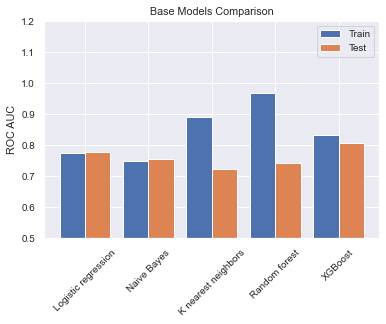

In [434]:
xpos = np.arange(5)
plt.bar(xpos-0.2, train_roc_aucs, width=0.4, label="Train")
plt.bar(xpos+0.2, test_roc_aucs, width=0.4, label="Test")
plt.xticks(xpos, model_names, rotation=45)
plt.title("Base Models Comparison")
plt.ylabel("ROC AUC")
plt.ylim(0.5, 1.2)
plt.legend(loc="best")
plt.show()

* XGBoot has the is best model considering both the roc_auc score (bias) and overfitting issue (variance)

### 4.5 Model optimization

In [435]:
# Gridserach to find the best hyper parameters

params = {
#           'min_child_weight': [1, 3],
#           'gamma': [0, 1],
#           'colsample_bytree': [0.6, 1],
          'n_estimators': [100, 200],
          'reg_alpha': [0, 1],
          'reg_lambda': [0, 0.1, 1],
          'max_depth': [2, 3, 4]}

model = model_xgb
scorer = make_scorer(roc_auc_score)
clf = GridSearchCV(model, params, scoring=scorer)

clf.fit(X_train, y_train)
results = clf.cv_results_
best_model = clf.best_estimator_

In [436]:
model = best_model
model

XGBClassifier(max_depth=4, n_estimators=200, random_state=42, reg_alpha=1,
              reg_lambda=0)

### 4.6 Model prediction

In [437]:
model.fit(X_train, y_train)

y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

train_score = round(roc_auc_score(y_train, y_train_proba[:, 1]), 4)
test_score = round(roc_auc_score(y_test, y_test_proba[:, 1]), 4)
print(model_names[idx] + "roc_auc" + f"| Train: {train_score} " + f"| Test:  {test_score}")

XGBoostroc_auc| Train: 0.8561 | Test:  0.8048


In [438]:
from sklearn.metrics import classification_report
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train report")
print(classification_report(y_train, y_train_pred))
print()
print("Test report")
print(classification_report(y_test, y_test_pred))

Train report
              precision    recall  f1-score   support

           0       0.83      0.86      0.84     18048
           1       0.69      0.65      0.67      9024

    accuracy                           0.79     27072
   macro avg       0.76      0.75      0.76     27072
weighted avg       0.78      0.79      0.78     27072


Test report
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     22577
           1       0.17      0.52      0.25      1270

    accuracy                           0.83     23847
   macro avg       0.57      0.69      0.58     23847
weighted avg       0.93      0.83      0.87     23847



### 4.7 Feature importance

In [439]:
feas = X_train.columns
fea_imps = model.feature_importances_

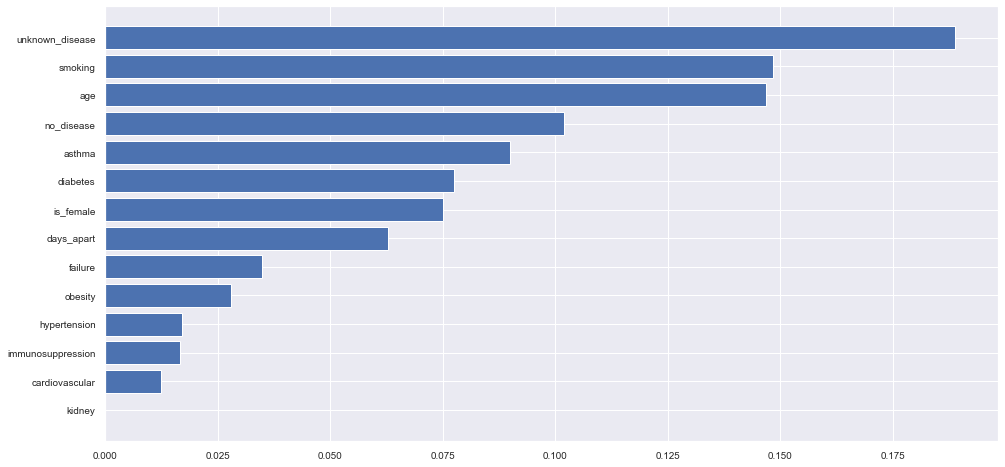

In [440]:
res = dict(sorted(zip(feas, fea_imps), key=lambda x: x[1]))

plt.figure(figsize=(16, 8))
plt.barh(range(len(res)), res.values())
plt.yticks(range(len(res)), res.keys())
plt.show()

In [441]:
is_severe_train = X_train[y_train == 1]
not_severe_train = X_train[y_train == 0]

is_severe_test = X_test[y_test == 1]
not_severe_test = X_test[y_test == 0]

In [485]:
# helper function to show the distribution on different features
def distribution(fea, ticks):
    '''Plot the target distribution on FEA (string)'''
    
    print('Distribution on ' + fea + ':')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
    
    ax1.hist(is_severe_train[fea], alpha=0.5, density=True, label='is severe')
    ax1.hist(not_severe_train[fea], alpha=0.5, density=True, label='not severe')
    ax1.set_title('train')
    ax1.legend(loc="best")
    ax1.set_xlabel(fea)
    ax1.set_xticks(ticks)
    
    ax2.hist(is_severe_test[fea], alpha=0.5, density=True, label='is severe')
    ax2.hist(not_severe_test[fea], alpha=0.5, density=True, label='not severe')
    ax2.set_title('test')
    ax2.legend(loc="best")
    ax2.set_xlabel(fea)
    ax2.set_xticks(ticks)
        
    plt.show()

Distribution on unknown_disease:


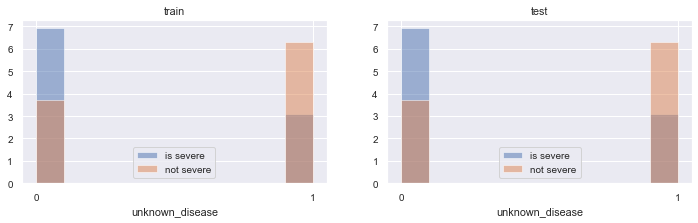

In [487]:
fea = 'unknown_disease'
ticks = X[fea].unique()
distribution(fea, ticks)

Distribution on smoking:


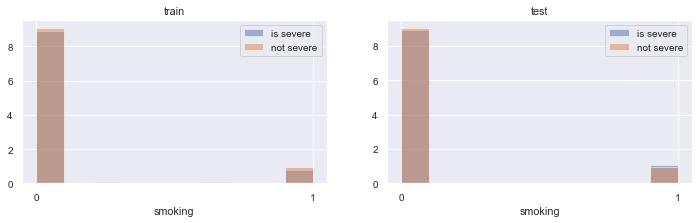

In [488]:
fea = 'smoking'
ticks = X[fea].unique()
distribution(fea, ticks)

Distribution on age:


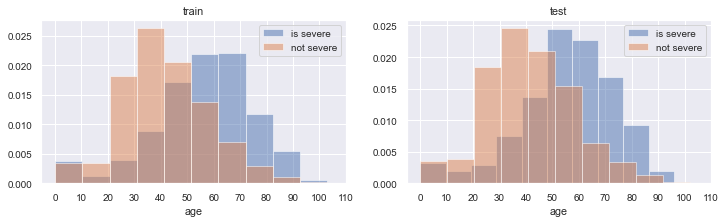

In [489]:
fea = 'age'
ticks = mex_df["age_band"].dropna().unique()
distribution(fea, ticks)

Distribution on no_disease:


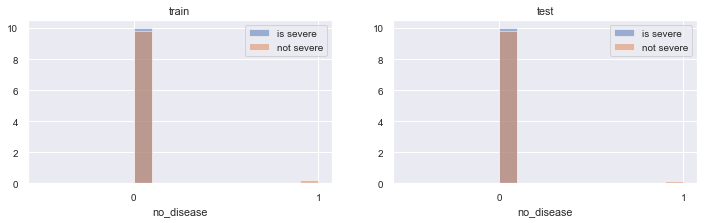

In [490]:
fea = 'no_disease'
ticks = X[fea].unique()
distribution(fea, ticks)

Distribution on is_female:


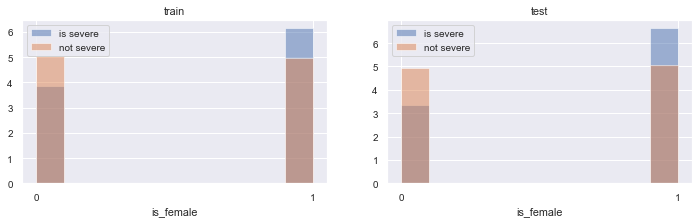

In [491]:
fea = 'is_female'
ticks = X[fea].unique()
distribution(fea, ticks)

Distribution on asthma:


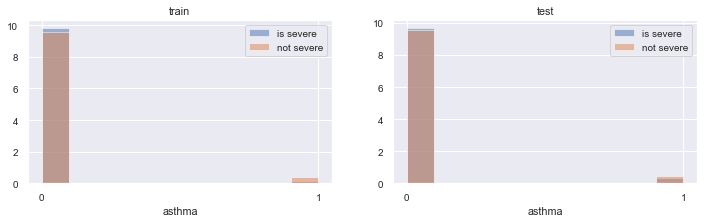

In [492]:
fea = 'asthma'
ticks = X[fea].unique()
distribution(fea, ticks)

### 4.8 Summary

1. Aged people, especially those who have background diseases should be more cautious about COVID-19.
2. Female seems to be slightly more vulnerable to covid 19